<a href="https://colab.research.google.com/github/cmannnn/practical_deep_learning_for_coders/blob/main/deep_learning_for_coders_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#hide
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 24.3MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 1.2MB 46.8MB/s 
     |████████████████████████████████| 204kB 48.7MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
Mounted at /content/gdrive


In [4]:
#hide
from fastbook import *

# Chapter 1

## ResNet Cat/dog predictor

In [ ]:
#id first_training
#caption Results from the first training
# CLICK ME
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct = 0.2, seed = 42,
    label_func=is_cat, item_tfms=Resize(224))

learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(1)

In [ ]:
#hide_output
uploader = widgets.FileUpload()
uploader

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
uploader = SimpleNamespace(data = ['/content/doggo.jpeg'])
uploader

In [ ]:
img = PILImage.create(uploader.data[0])
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

## LSTM movie NLP model

In [ ]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid = 'test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult = 0.5, metrics = accuracy)
learn.fine_tune(4, 1e-2)

In [ ]:
learn.predict("I really liked that movie!")

## Socioeconomic indicator

In [ ]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path = path, y_names = "salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics = accuracy)

In [ ]:
learn.fit_one_cycle(3)

## Movie predictor

In [ ]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range = (0.5, 5.5))
learn.fine_tune(10)

In [ ]:
learn.show_results()

# Chapter 2

## Bear classifier

In [6]:
key = os.environ.get('AZURE_SEARCH_KEY', 'xxx')

In [7]:
search_images_bing

<function fastbook.search_images_bing>

In [8]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

150

In [9]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [10]:
dest = 'images'
download_url(ims[0], dest)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


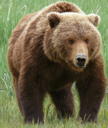

In [12]:
im = Image.open(dest)
im.to_thumb(128,128)

In [13]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [14]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [15]:
fns = get_image_files(path)
fns

(#395) [Path('bears/black/00000079.jpg'),Path('bears/black/00000114.jpg'),Path('bears/black/00000058.jpg'),Path('bears/black/00000091.png'),Path('bears/black/00000042.jpg'),Path('bears/black/00000077.jpg'),Path('bears/black/00000066.jpg'),Path('bears/black/00000133.jpg'),Path('bears/black/00000095.jpg'),Path('bears/black/00000000.jpg')...]

In [16]:
failed = verify_images(fns)
failed

(#7) [Path('bears/black/00000120.jpg'),Path('bears/black/00000032.jpg'),Path('bears/teddy/00000096.jpg'),Path('bears/grizzly/00000043.jpg'),Path('bears/grizzly/00000076.jpg'),Path('bears/grizzly/00000014.jpg'),Path('bears/grizzly/00000095.png')]

In [17]:
failed.map(Path.unlink)

(#7) [None,None,None,None,None,None,None]

In [18]:
bears = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms=Resize(128))

In [19]:
dls = bears.dataloaders(path)

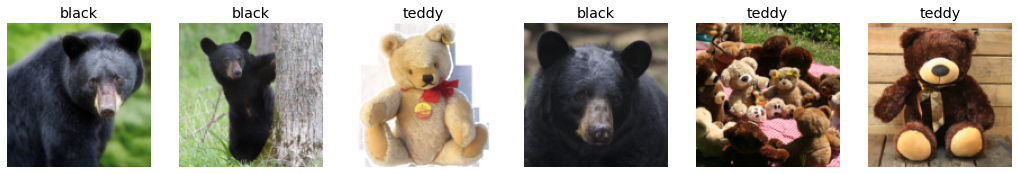

In [20]:
dls.valid.show_batch(max_n = 6, nrows = 1)

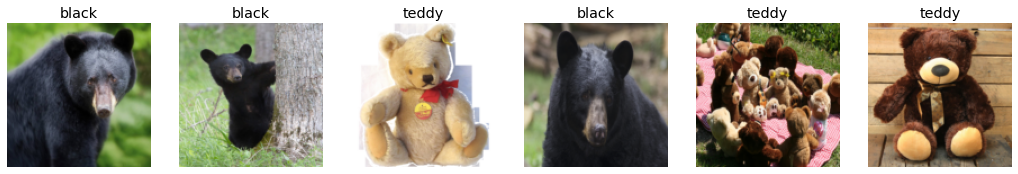

In [21]:
bears = bears.new(item_tfms = Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n = 6, nrows = 1)

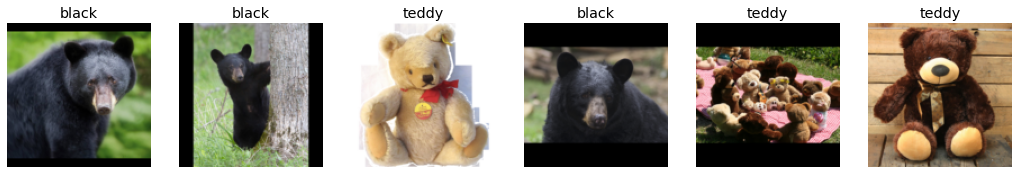

In [22]:
bears = bears.new(item_tfms = Resize(128, ResizeMethod.Pad, pad_mode = 'zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n = 6, nrows = 1)

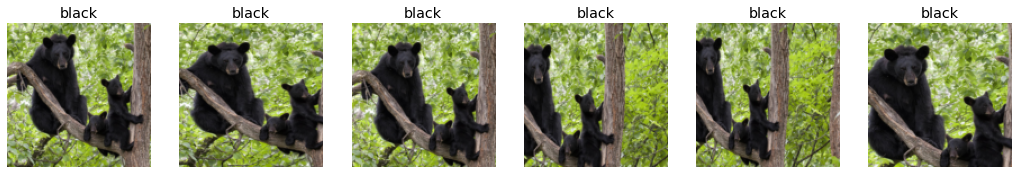

In [23]:
bears = bears.new(item_tfms = RandomResizedCrop(128, min_scale = 0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n = 6, nrows = 1, unique = True)

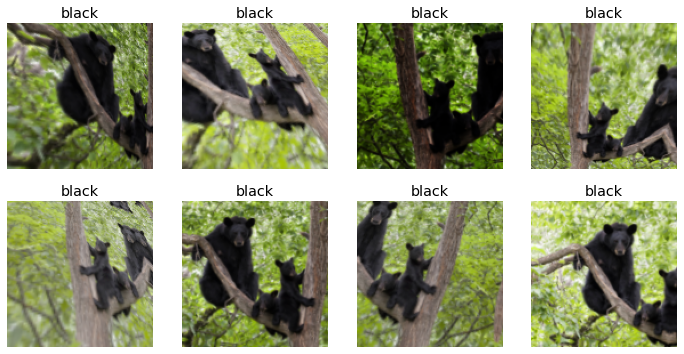

In [24]:
bears = bears.new(item_tfms = Resize(128), batch_tfms = aug_transforms(mult = 2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n = 8, nrows = 2, unique = True)

In [25]:
bears = bears.new(
    item_tfms = RandomResizedCrop(224, min_scale = 0.5),
    batch_tfms = aug_transforms())
dls = bears.dataloaders(path)

In [26]:
learn = cnn_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.800269,0.091944,0.038961,00:19


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.287137,0.032334,0.012987,00:19
1,0.185344,0.017669,0.012987,00:20
2,0.140726,0.020324,0.012987,00:19
3,0.108780,0.021837,0.012987,00:19


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

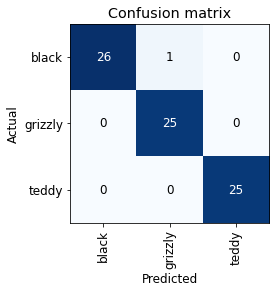

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

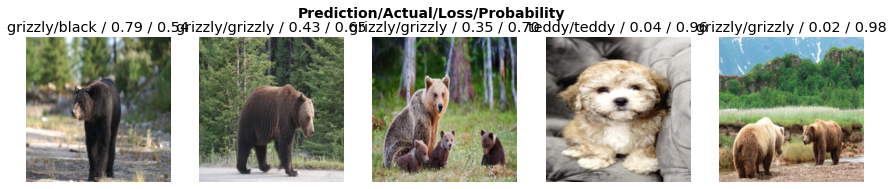

In [28]:
interp.plot_top_losses(5, nrows=1)

In [29]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

NameError: ignored

In [ ]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)